# rechunker depth loop

In [1]:
Author_dict = {"name": "Thomas Moore", 
               "affiliation": "CSIRO", 
               "email": "thomas.moore@csiro.au",
               "orchid_ID":'https://orcid.org/0000-0003-3930-1946'}

In [2]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from dask.distributed import Client, LocalCluster
import dask
import datetime
import zarr

from rechunker import rechunk

import gc
import sys
import subprocess
from tabulate import tabulate
import os

# functions

In [3]:
def get_package_version(package):
    # Command to get package version using pip
    command = [sys.executable, '-m', 'pip', 'show', package]
    try:
        # Run the command and capture the output
        result = subprocess.run(command, stdout=subprocess.PIPE, text=True, check=True)
        # Parse the result to find the version line
        for line in result.stdout.split('\n'):
            if 'Version:' in line:
                return line.split(': ')[1].strip()
    except subprocess.CalledProcessError:
        # Return None if the package is not found
        return None
        
def version_table(packages = None ):
    if packages is None:
        packages = []
    # Now you can safely modify list as needed
    packages.extend(['numpy', 'xarray','dask','scipy','numba','numbagg','flox','bottleneck'])
    # Prepare data for tabulation
    table = []
    for package in packages:
        version = get_package_version(package)
        if version is None:
            version = "Not installed"
        table.append([package, version])
    
    # Adjust the table to fit a max of 4 records per column set
    max_rows = 4
    num_columns = (len(table) + max_rows - 1) // max_rows  # Calculate number of columns needed
    multi_column_table = []
    
    for i in range(max_rows):
        row = []
        for j in range(num_columns):
            index = j * max_rows + i
            if index < len(table):
                row.extend(table[index])
            else:
                row.extend(['', ''])  # Fill empty spaces if no more packages
        multi_column_table.append(row)

    # Define headers for the multi-column table
    headers = []
    for i in range(num_columns):
        headers.extend(['Package', 'Version'])

    # Print the table using tabulate
    print(tabulate(multi_column_table, headers=headers, tablefmt='grid'))

def keep_only_selected_vars(ds, vars_to_keep=['salt','Time','st_ocean','yt_ocean','xt_ocean']):
    # Calculate which variables to drop by finding the difference
    # between all variables in the dataset and the ones you want to keep
    vars_to_drop = set(ds.variables) - set(vars_to_keep)
    return ds.drop_vars(list(vars_to_drop))

def print_chunks(data_array):
    chunks = data_array.chunks
    dim_names = data_array.dims
    readable_chunks = {dim: chunks[i] for i, dim in enumerate(dim_names)}
    for dim, sizes in readable_chunks.items():
        print(f"{dim} chunks: {sizes}")
    return readable_chunks

def remove_zarr_encoding(DS):
    for var in DS:
        DS[var].encoding = {}

    for coord in DS.coords:
        DS[coord].encoding = {}
    return DS

def rechunk_each_st_ocean(ds, level_index,chunking_dict):
    # Select the specific level
    ds_level = ds.isel(st_ocean=level_index)

    # Rechunk the dataset for this level to include all time points
    # Adjust lat and lon to fit within memory constraints
    print('--- chunking dict ---',chunking_dict)
    ds_level_rechunked = ds_level.chunk(chunking_dict)
    print('>>> depth index: ',level_index,' START')
    ds_level_rechunked = remove_zarr_encoding(ds_level_rechunked)
    print(ds_level_rechunked)
    print(ds_level_rechunked.encoding)
    print_chunks(ds_level_rechunked.salt)

    # Save or return the result
    workspace = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/looped_rechunk_output/'
    encoding_values = tuple(chunking_dict.values())
    encoding = {'salt':{'chunks':encoding_values}}
    print('encoding: '+ str(encoding))
    ds_level_rechunked.to_zarr(workspace+f'st_ocean_{level_index}_rechunked.zarr',mode='w', encoding=encoding, consolidated=True)
    print('depth index: ',level_index,' FINISH <<< ')
    
    
    
def concatinate_st_ocean_zarrs(zarr_dir_path = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/looped_rechunk_output/'):
    # Assuming all Zarr directories are in the same folder
    zarr_stores = [os.path.join(zarr_dir_path, d) for d in os.listdir(zarr_dir_path) if os.path.isdir(os.path.join(zarr_dir_path, d))]

    # Load all Zarr stores as a list of xarray datasets
    datasets = [xr.open_zarr(store, consolidated=True) for store in zarr_stores]

    # Concatenate all datasets along the level dimension
    all_depths_ds = xr.concat(datasets, dim='st_ocean')

    # Save the combined dataset to a new Zarr store
    all_depths_ds.to_zarr(zarr_dir_path+'combined_output.zarr', consolidated=True)

def clear_and_restart(variables, client):
    """
    Clear specified variables from memory, collect garbage, and restart the Dask cluster.

    Args:
        variables (list): List of string names of the variables to clear from the namespace.
        client (dask.distributed.Client): The Dask client associated with the cluster to restart.

    Returns:
        None
    """

    # Clear specified variables
    for var in variables:
        if var in globals():
            del globals()[var]
    
    # Collect garbage
    gc.collect()
    
    # Restart the Dask cluster
    client.restart()

In [4]:
version_table(packages = ['rechunker','zarr'])

+-----------+-----------+-----------+-----------+------------+-----------+
| Package   | Version   | Package   | Version   | Package    | Version   |
+===========+===========+===========+===========+============+===========+
| rechunker | 0.5.2     | dask      | 2024.4.0  | flox       | 0.9.6     |
+-----------+-----------+-----------+-----------+------------+-----------+
| zarr      | 2.17.1    | scipy     | 1.12.0    | bottleneck | 1.3.8     |
+-----------+-----------+-----------+-----------+------------+-----------+
| numpy     | 1.26.4    | numba     | 0.59.1    |            |           |
+-----------+-----------+-----------+-----------+------------+-----------+
| xarray    | 2024.3.0  | numbagg   | 0.8.1     |            |           |
+-----------+-----------+-----------+-----------+------------+-----------+


# cluster

In [5]:
#cluster=LocalCluster(n_workers=28,processes=True)#,threads_per_worker=1)
#cluster=LocalCluster()
#cluster=LocalCluster(n_workers=32,threads_per_worker=1,memory_limit='85GB')
cluster=LocalCluster(n_workers=28,threads_per_worker=1,memory_limit='32GB')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 834.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41701,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 834.47 GiB
Comm: tcp://127.0.0.1:42127,Total threads: 1
Dashboard: /proxy/46131/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:36843,


In [6]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/'
datestamp = 'v11052024'
var = 'salt'

# load from `netcdf` and write to ...

In [ ]:
xarray_open_kwargs = {"Time": 1, "st_ocean": 51, "xt_ocean": 3600, "yt_ocean": 1500}
ds = xr.open_mfdataset('/g/data/gb6/BRAN/BRAN2020/daily/ocean_'+var+'_*.nc',
                       parallel=True,chunks=xarray_open_kwargs,preprocess=keep_only_selected_vars)
ds

In [ ]:
chunking_string = 'chunks_' + ''.join(str(key) + str(value)+ '.' for key, value in xarray_open_kwargs.items())
ard_rcTime_file_ID = 'BRAN2020-'+var+'-'+chunking_string+datestamp+'.zarr'

In [ ]:
ard_rcTime_file_ID

In [ ]:
%%time
ds.to_zarr(BRAN2020_ard_path+ard_rcTime_file_ID,consolidated=True)

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/rechunk_done.log

# load the resulting float64 zarr and write to float32

In [ ]:
ds_1_51_3600_1500_float64 = xr.open_zarr(BRAN2020_ard_path+ard_rcTime_file_ID,consolidated=True)

In [ ]:
ds_1_51_3600_1500_float32 = ds_1_51_3600_1500_float64.copy(deep=True)

In [ ]:
ds_1_51_3600_1500_float32['salt'] = ds_1_51_3600_1500_float64.salt.astype('float32')

In [ ]:
ds_1_51_3600_1500_float32


In [ ]:
%%time
ds_1_51_3600_1500_float32.to_zarr(BRAN2020_ard_path+'float32.'+ard_rcTime_file_ID,consolidated=True)


In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/float32_write_done.log

# load the float32 `ds_1_51_3600_1500`

In [ ]:
ds_1_51_3600_1500_float32_reloaded = xr.open_zarr(BRAN2020_ard_path+'float32.BRAN2020-salt-chunks_Time1.st_ocean51.xt_ocean3600.yt_ocean1500.v08052024.zarr',
                                                  consolidated=True)
ds_1_51_3600_1500_float32_reloaded

In [ ]:
readable_chunks = print_chunks(ds_1_51_3600_1500_float32_reloaded.salt)

# chunking

In [ ]:
chunking_dict_per_depth = {"Time": 11322, "xt_ocean": 120, "yt_ocean": 120}

In [ ]:
ds_1_51_3600_1500_float32_reloaded.isel(st_ocean=0).chunk(chunking_dict_per_depth)

In [ ]:
%%time
# Iterate over each depth and process
for depth_index in range(13,15):
    rechunk_each_st_ocean(ds_1_51_3600_1500_float32_reloaded, depth_index,chunking_dict=chunking_dict_per_depth)

In [ ]:
%%time
concatinate_st_ocean_zarrs()

In [7]:
plot_data = xr.open_zarr('/scratch/es60/ard/reanalysis/BRAN2020/ARD/looped_rechunk_output/combined_output.zarr',consolidated=True)

In [ ]:
%%time
plot_me = plot_data.salt.quantile([0.95],dim='Time',skipna=False).mean(dim='st_ocean',skipna=False).compute()

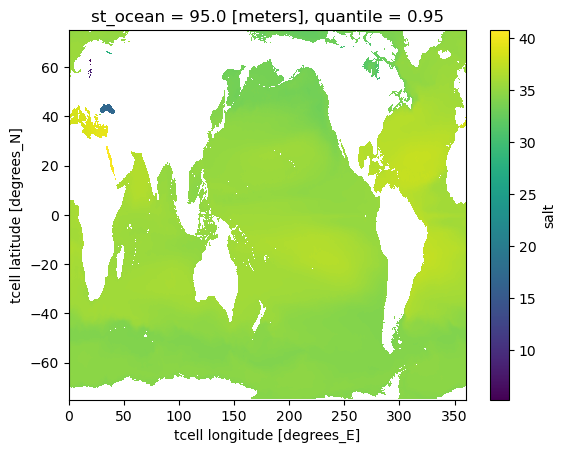

In [10]:
plot_me.plot()

In [ ]:
chunking_string_1st = 'chunks_' + ''.join(str(key) + str(value)+ '.' for key, value in chunking_1st_dict.items())
ard_rc1_file_ID = 'BRAN2020-'+var+'-'+chunking_string_1st+datestamp+'.zarr'
ard_rc1_file_ID

In [ ]:
ds_11322_1_30_30 = ds_1_51_3600_1500_float32_reloaded.copy(deep=True).chunk(chunking_1st_dict)
ds_11322_1_30_30

In [ ]:
BRAN2020_ard_path+ard_rc1_file_ID

In [ ]:
ds_11322_1_30_30 = remove_zarr_encoding(ds_11322_1_30_30)

In [ ]:
%%time
ds_11322_1_30_30.to_zarr(BRAN2020_ard_path+ard_rc1_file_ID,consolidated=True)

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/rechunk_11322_done.log

# netcdf to first zarr

In [ ]:
xarray_open_kwargs = {"Time": 1, "st_ocean": 5, "xt_ocean": 3600, "yt_ocean": 1500}
ds = xr.open_mfdataset('/g/data/gb6/BRAN/BRAN2020/daily/ocean_salt_*.nc',parallel=True,chunks=xarray_open_kwargs,preprocess=keep_only_selected_vars)
ds

In [ ]:
%%time
ds.astype('float32').to_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)

# load first zarr

In [ ]:
ds_1_5_1500_3600 = xr.open_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)

In [ ]:
ds_1_5_1500_3600

In [ ]:
chunking_dict={'Time':500,'xt_ocean':150}

In [ ]:
ds_1_5_1500_3600.chunk(chunking_dict)

In [ ]:
var='salt'

In [ ]:
chunking_string = 'chunks_'+''.join(str(key) + str(value) for key, value in chunking_dict.items())
ard_rcTime_file_ID = 'BRAN2020-'+var+'-'+chunking_string+'-v07052024.zarr'

In [ ]:
ds_1_5_1500_3600 = remove_zarr_encoding(ds_1_5_1500_3600)

In [ ]:
from rechunker import rechunk
!rm -rf /scratch/es60/ard/reanalysis/BRAN2020/ARD/temp_store/*
# Define target chunking
target_chunks = chunking_dict
target_store = BRAN2020_ard_path+ard_rcTime_file_ID
temp_store = BRAN2020_ard_path+'temp_store'  # Optional based on dataset size

# Execute rechunking
rechunk_plan = rechunk(ds_1_5_1500_3600, target_chunks, target_store=target_store, temp_store=temp_store,max_mem='8GB')

In [ ]:
%%time
rechunk_plan.execute()

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/rechunk_done.log

In [ ]:
zarr.consolidate_metadata(target_store)
ds_all_1_150_150 = xr.open_zarr(target_store,consolidated=True)

In [ ]:
ds_all_1_150_150